In [2]:
import requests
from matplotlib import pyplot as plt
import numpy as np
import json
from PIL import Image
from io import BytesIO

In [3]:
seriesid = '4240' # corresponds to viewer3 link http://braincircuits.org/viewer3/mouse/map/4240 

In [4]:

def get_initial_section(serid):
# initial section as in db
  apiurl = 'http://mitradevel.cshl.org/webtools/seriesbrowser'
  resp = requests.get(apiurl + '/getinitialsection/'+str(serid)).json()
  return resp["N"]

sectionid = get_initial_section(seriesid)
print(sectionid)

914189


In [8]:
thumbnails = {}

def get_thumbnails():
  thumbnails = {}
  url = "http://mitradevel.cshl.org/webtools/seriesbrowser/getthumbnails/4240/"
  req = requests.get(url).json()
  req = req['N']
  for i in req:
    thumbnails[i[0]] = i[1:]
  return thumbnails
thumbnails = get_thumbnails()

def getJp2path(sec_no):
    global thumbnails
    return thumbnails[sec_no][0].replace("&","%26").replace("jpg","jp2")

path = getJp2path(25)
print(path)
    


/brainimg/PMD2057/PMD2057%262056-N9-2015.03.12-02.58.18_PMD2057_1_0025.jp2


In [ ]:
def getjp2path(secid):
    apiurl = 'http://mitradevel.cshl.org/webtools/seriesbrowser'
    resp = requests.get(apiurl + '/getsectionjp2path/'+str(secid))
    resp_dict = json.loads(resp.content)
    return resp_dict['jp2Path'].replace('&','%26')

jp2path = getjp2path(sectionid)
print(jp2path)
# def get_jp2path(brainno, secno):
#     apiurl = 'http://mitradevel.cshl.org/webtools/seriesbrowser'
#     sectionid = get_sectionid(get_seriesid(brainno),secno)
#     return getjp2path(sectionid)



/brainimg/PMD2057/PMD2057%262056-N9-2015.03.12-02.58.18_PMD2057_1_0025.jp2


In [ ]:
regionid = '440'

In [10]:
def get_iiifinfo(jp2pth):
    iipbase = "http://braincircuits.org/cgi-bin/iipsrv.fcgi"
    jp2p = '/'.join(jp2pth.split('/')[2:])
    print(iipbase + '?IIIF=/'+jp2p+'/info.json')
    resp = requests.get(iipbase + '?IIIF=/'+jp2p+'/info.json')
    
    resp_dict = json.loads(resp.content)
    return resp_dict['width'], resp_dict['height']

wid,hei = get_iiifinfo(path)
print(wid,hei)

http://braincircuits.org/cgi-bin/iipsrv.fcgi?IIIF=/PMD2057/PMD2057%262056-N9-2015.03.12-02.58.18_PMD2057_1_0025.jp2/info.json
24000 24000


In [ ]:
# http://braincircuits.org/annotation_tool/pixel.html?series_id=4240&section=25&color=R

In [ ]:
x = 13400 - 512
y = -11210 - 512

xpc = x/wid
ypc = -y/hei

xpc,ypc

(0.537, 0.48841666666666667)

In [ ]:
#http://braincircuits.org/cgi-bin/iipsrv.fcgi?FIF=/PMD2057/PMD2057%262056-F9-2015.03.06-17.55.48_PMD2057_1_0025.jp2&GAM=1&WID=1024&RGN=0.512,0.4266666666666667,0.042666666666666665,0.042666666666666665&MINMAX=1:10,255&MINMAX=3:10,255&MINMAX=2:10,255&CVT=jpeg

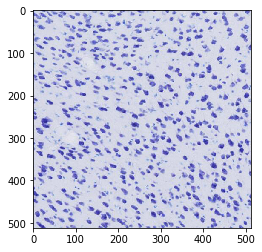

In [14]:
def get_tile(xpc,ypc,sec_no):
  path = getJp2path(sec_no).replace("/brainimg","")
  base_url = "http://braincircuits.org/cgi-bin/iipsrv.fcgi?FIF={3}&GAM=1&WID=512&RGN={0},{1},{2},{2}&MINMAX=1:10,255&MINMAX=3:10,255&MINMAX=2:10,255&CVT=jpeg".format(xpc,ypc,0.0427/2,path)
  res = requests.get(base_url)
  #print(base_url)
  img = Image.open(BytesIO(res.content))
  img_arr = np.array(img)
  return img_arr
img = get_tile(0.512,0.4266666666666667,25) 
plt.imshow(img)

In [56]:
from skimage.color import rgb2gray
from skimage.segmentation import felzenszwalb, slic, quickshift, watershed
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float

In [168]:
segments_slic = slic(img, n_segments=500, compactness=10, sigma=1)

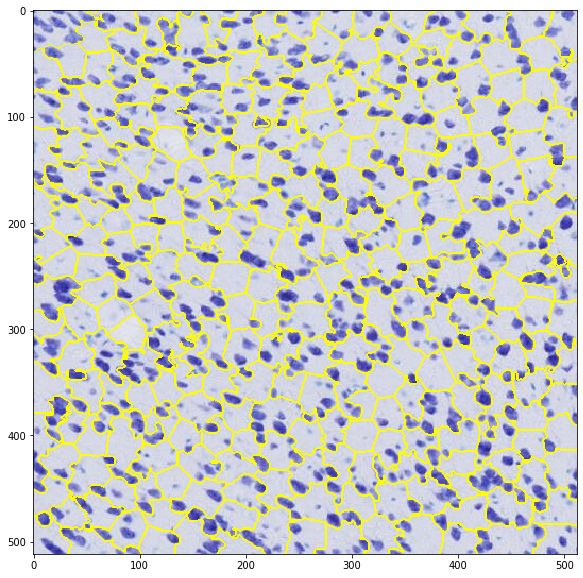

In [169]:
plt.figure(figsize = (10,10))
plt.imshow(mark_boundaries(img, segments_slic))

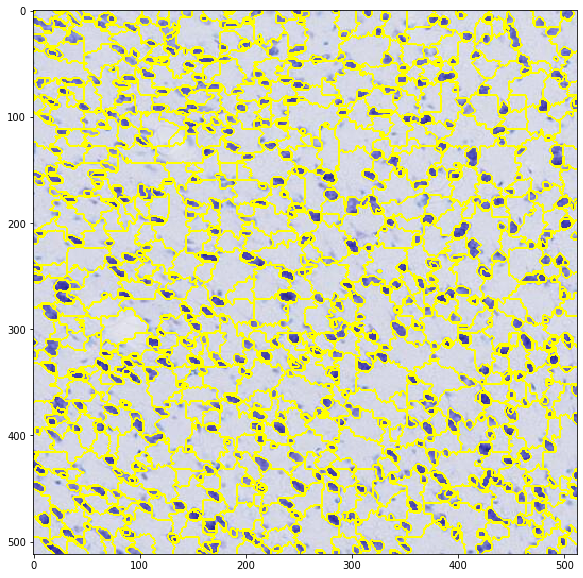

In [170]:
segments_quick = quickshift(img, kernel_size=3, max_dist=6, ratio=0.5)
plt.figure(figsize = (10,10))
plt.imshow(mark_boundaries(img, segments_quick))

In [171]:
from sklearn.cluster import KMeans

In [172]:
k_means = KMeans(n_clusters=2)

In [173]:
labels = np.unique(segments_quick)
print(labels)

[   0    1    2 ... 1398 1399 1400]


In [174]:
dic_means = {} 
for l in labels:
 mean = 0
 intensity = []
 X,Y = np.where(segments_quick == l)
 for i in range(len(X)):
   intensity.append(img[X[i],Y[i],:])
 mean = np.array(intensity).mean(axis = 0) 
 dic_means[l] = mean 

print(dic_means)

{0: array([137., 139., 164.]), 1: array([113.        , 107.83333333, 179.        ]), 2: array([ 98.9, 100.1, 221.5]), 3: array([ 95.18181818,  97.90909091, 190.09090909]), 4: array([101.125 , 104.4375, 172.6875]), 5: array([136.        , 140.69230769, 195.92307692]), 6: array([100.64285714, 106.        , 188.78571429]), 7: array([115.3125, 119.8125, 186.6875]), 8: array([116.38372093, 120.59302326, 193.8255814 ]), 9: array([195.3902439 , 201.65853659, 227.65853659]), 10: array([194.93243243, 198.60135135, 228.32432432]), 11: array([207.93975904, 212.10843373, 230.63855422]), 12: array([160.375   , 170.546875, 215.546875]), 13: array([205.73553719, 207.92561983, 227.7768595 ]), 14: array([100.28947368,  96.63157895, 182.42105263]), 15: array([107.38297872, 110.87234043, 189.36170213]), 16: array([113.71875, 115.84375, 198.34375]), 17: array([198.72077922, 203.57792208, 227.74675325]), 18: array([193.05825243, 198.24757282, 226.83980583]), 19: array([162.41860465, 165.39534884, 219.53488

In [175]:
cluster = k_means.fit(list(dic_means.values())).labels_

In [176]:
array = np.zeros_like(segments_quick)

In [177]:
for i in range(segments_quick.shape[0]):
  for j in range(segments_quick.shape[1]):
    if cluster[segments_quick[i,j]] == 0:
      array[i,j] = 1


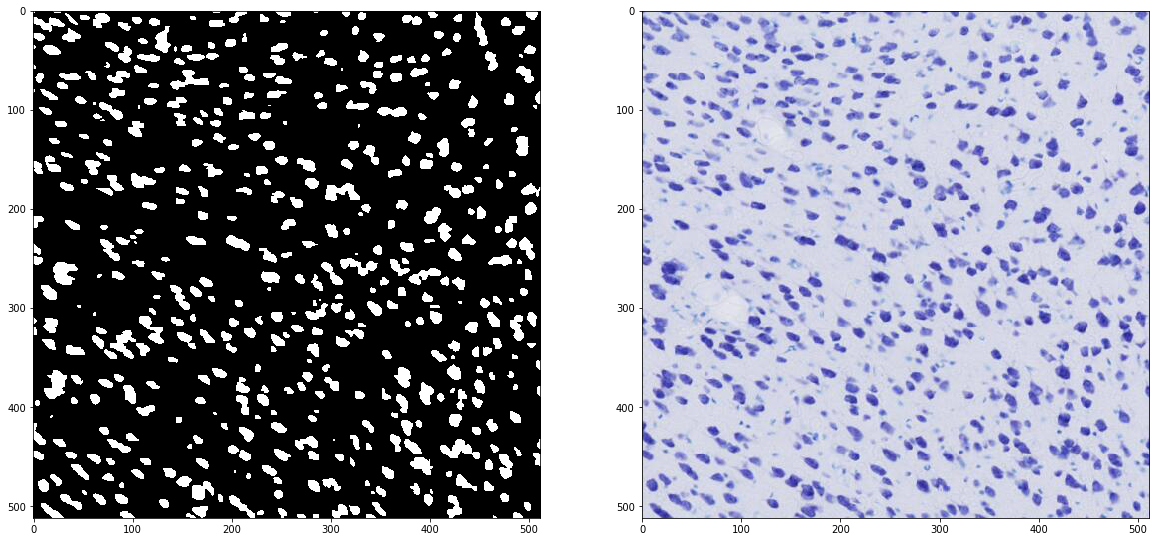

In [178]:
plt.figure(figsize = (20,10))
plt.subplot(1,2,1)
plt.imshow(array,cmap = "gray")
plt.subplot(1,2,2)
plt.imshow(img)

In [ ]:
pip install geojson

In [61]:
def get_regionExtent(slice_no,region_no):
  url = "http://mitradevel.cshl.org/webtools/seriesbrowser/getatlasgeojson/PMD2057/%.4d"%slice_no
  req = requests.get(url).json()
  req = req["features"]
  for feature in req:
    if feature["id"] == str(region_no):
      geomentry = np.array(feature["geometry"]["coordinates"][0][0])
      min = np.min(geomentry,axis = 0)
      max = np.max(geomentry,axis = 0)
     # print(min,max)
      tl = min[0],max[1]
      br = max[0],min[1]
      print(tl,br)
      hei = min[1] - max[1]
      wid = max[0] - min[0]
      
      points = []
      for point in geomentry:
        points.append((point[0] - tl[0],tl[1] - point[1]))
      return (tl[0],tl[1],abs(hei),wid,points)

coords = get_regionExtent(25,440)
#print(coords[-1])

(13074.0, -10970.0) (13694.0, -11506.0)


In [124]:
#try alogos
from skimage import data, io, segmentation, color
from skimage.future import graph
from skimage.segmentation import random_walker,chan_vese
from skimage.data import binary_blobs
from skimage.exposure import rescale_intensity
from skimage import img_as_float

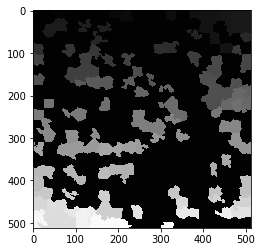

In [150]:
labels1 = segmentation.slic(img, compactness=50, n_segments=400)
g = graph.rag_mean_color(img, labels1)
rag_mean = graph.cut_threshold(labels1, g, 15)
plt.imshow(rag_mean,cmap = "gray")

In [125]:
gray = img_as_float(rgb2gray(img))
cv = chan_vese(gray, mu=0.25, lambda1=1, lambda2=1, tol=1e-3, max_iter=200,
               dt=0.5, init_level_set="checkerboard", extended_output=True)
#print(np.unique(gray))

In [122]:
# Run random walker algorithm
walker = random_walker(gray, markers, beta=0.001, mode='bf')

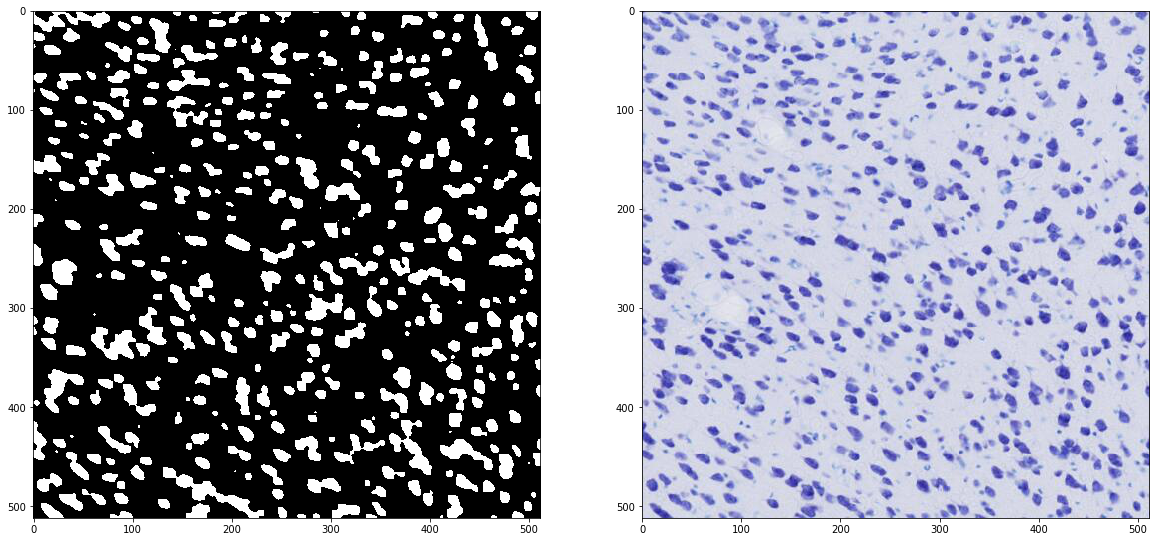

In [152]:
plt.figure(figsize = (20,10))
plt.subplot(1,2,1)
plt.imshow(cv[0],cmap = "gray")
plt.subplot(1,2,2)
plt.imshow(img)

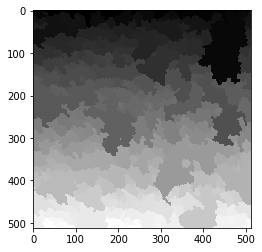

In [193]:
from skimage.morphology import watershed
from skimage.feature import peak_local_max
from skimage.filters import rank
from skimage.util import img_as_ubyte
image = array
from scipy import ndimage as ndi
import matplotlib.pyplot as plt

from skimage.morphology import watershed, disk
image = img_as_ubyte(rgb2gray(img))

# denoise image
denoised = rank.median(image, disk(2))

# find continuous region (low gradient -
# where less than 10 for this image) --> markers
# disk(5) is used here to get a more smooth image
markers = rank.gradient(denoised, disk(5)) < 10
markers = ndi.label(markers)[0]

# local gradient (disk(2) is used to keep edges thin)
gradient = rank.gradient(denoised, disk(2))

# process the watershed
watershed = watershed(gradient, markers)
plt.imshow(watershed,cmap = "gray")

In [195]:
labels = np.unique(watershed)
print(labels)
#np.where(watershed == 3)

[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234
 235 236 237 238 239 240 241 242 243 244 245 246 24

(array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,
         2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
         2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
         3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  4,  4,  4,
         4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
         4,  4,  4,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
         5,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  6,  6,
         6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  7,  7,
         7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
         7,  7,  7,  7,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
         8, 

In [201]:
means = {}
for l in labels:
    x,y = np.where(watershed == l)
    #print(x,y,"\n\n\n")
    intensity = []
    mean = 0
    for i in range(len(x)):
        intensity.append(img[x[i],y[i],:])
    mean = np.array(intensity).mean(axis = 0)
    means[l] = mean
print(len(means))    

431


In [218]:
cluster = k_means.fit(list(means.values())).labels_
print(cluster)

[0 0 0 0 0 1 1 1 0 1 0 0 0 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 0 1 1 0 0 0 1 1 1 1 0 0 1 1 1 0 1 1 0 1 0 1 1 1 0 1 1 1
 0 1 1 0 0 0 1 1 1 0 1 1 0 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1
 1 1 0 0 1 1 1 1 1 1 1 1 1 0 0 1 1 0 1 1 1 1 1 0 1 0 1 1 1 1 1 0 0 1 1 1 1
 1 0 0 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1 0 1 1 1 0 1
 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 0 1 1 1 0 1 0 1 1
 1 1 1 0 0 1 0 0 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 0 1 0 1
 1 0 0 0 1 1 0 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1
 1 1 0 1 1 0 1 1 1 0 0 1 1 0 1 0 1 1 1 1 1 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 1 1 1 0 1 1 1 0 0 1 1 1 1 0 1 1 0 1 1 1 0 0 1 0 1 1 1 1 1 0 0 1
 1 1 0 0 1 1 0 0 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 0 0 0 1 0 1 0 1 1 1 0 0 0 1
 1 0 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 0 0 1 1 0 1 1]


In [217]:
array = np.zeros_like(watershed)
watershed.shape

(512, 512)

In [219]:
for i in range(watershed.shape[0]):
    for j in range(watershed.shape[1]):
        if cluster[watershed[i,j]-1] == 0:
            array[i,j] = 1

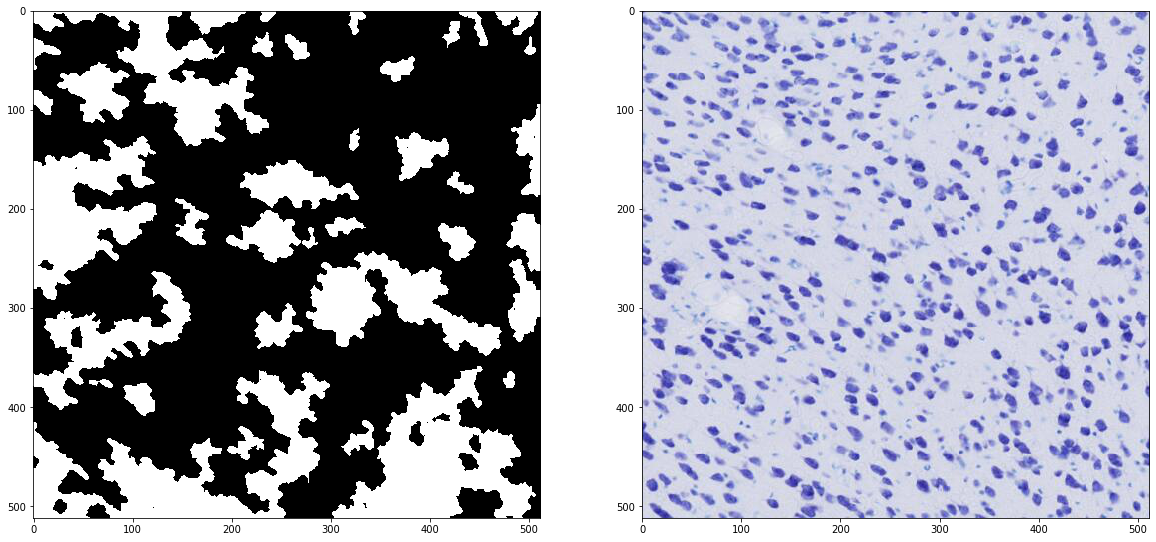

In [220]:
plt.figure(figsize = (20,10))
plt.subplot(1,2,1)
plt.imshow(array,cmap = "gray")
plt.subplot(1,2,2)
plt.imshow(img)